# Harmony Request Cost Estimation

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import xgboost

## Read Request Data

In [2]:
# df = pd.read_csv("./2000-requests-7-concurrent-users-sandbox.csv")
df = pd.read_csv("./266Requests-1-100-random-service-example-granules.csv")
# df = pd.read_csv("./30-requests.csv")

In [3]:
df.head(5)

,totalTime,numInputGranules,totalGranuleSize,harmonyGdalAdapter,harmonyServiceExample,harmonyNetcdfToZarr,swotReproject,varSubsetter,sdsMaskfill,trajectorySubsetter,podaacConcise,podaacL2Subsetter,giovanniAdapter
0,58.345,97,48.105550,0,1,0,0,0,0,0,0,0,0
1,9.543,13,6.248296,0,1,0,0,0,0,0,0,0,0
2,52.436,91,45.308758,0,1,0,0,0,0,0,0,0,0
3,19.934,27,13.865444,0,1,0,0,0,0,0,0,0,0
4,35.123,66,32.991564,0,1,0,0,0,0,0,0,0,0


## See How Correlated the Features Are

In [4]:
#  This function does the actual graphical plotting of the correlation matrix.  
def plot_corr(df, size=25):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap=plt.cm.RdYlGn, norm=colors.Normalize(vmin=0, vmax=1))
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=70)
    plt.yticks(range(len(corr.columns)), corr.columns)
    fig.colorbar(cax)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    fig.savefig('corr_mat.png', bbox_inches='tight')

In [5]:
df.corr()

,totalTime,numInputGranules,totalGranuleSize,harmonyGdalAdapter,harmonyServiceExample,harmonyNetcdfToZarr,swotReproject,varSubsetter,sdsMaskfill,trajectorySubsetter,podaacConcise,podaacL2Subsetter,giovanniAdapter
totalTime,1.000000,0.672653,0.671803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numInputGranules,0.672653,1.000000,0.999764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalGranuleSize,0.671803,0.999764,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
harmonyGdalAdapter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
harmonyServiceExample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
harmonyNetcdfToZarr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
swotReproject,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
varSubsetter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sdsMaskfill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trajectorySubsetter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


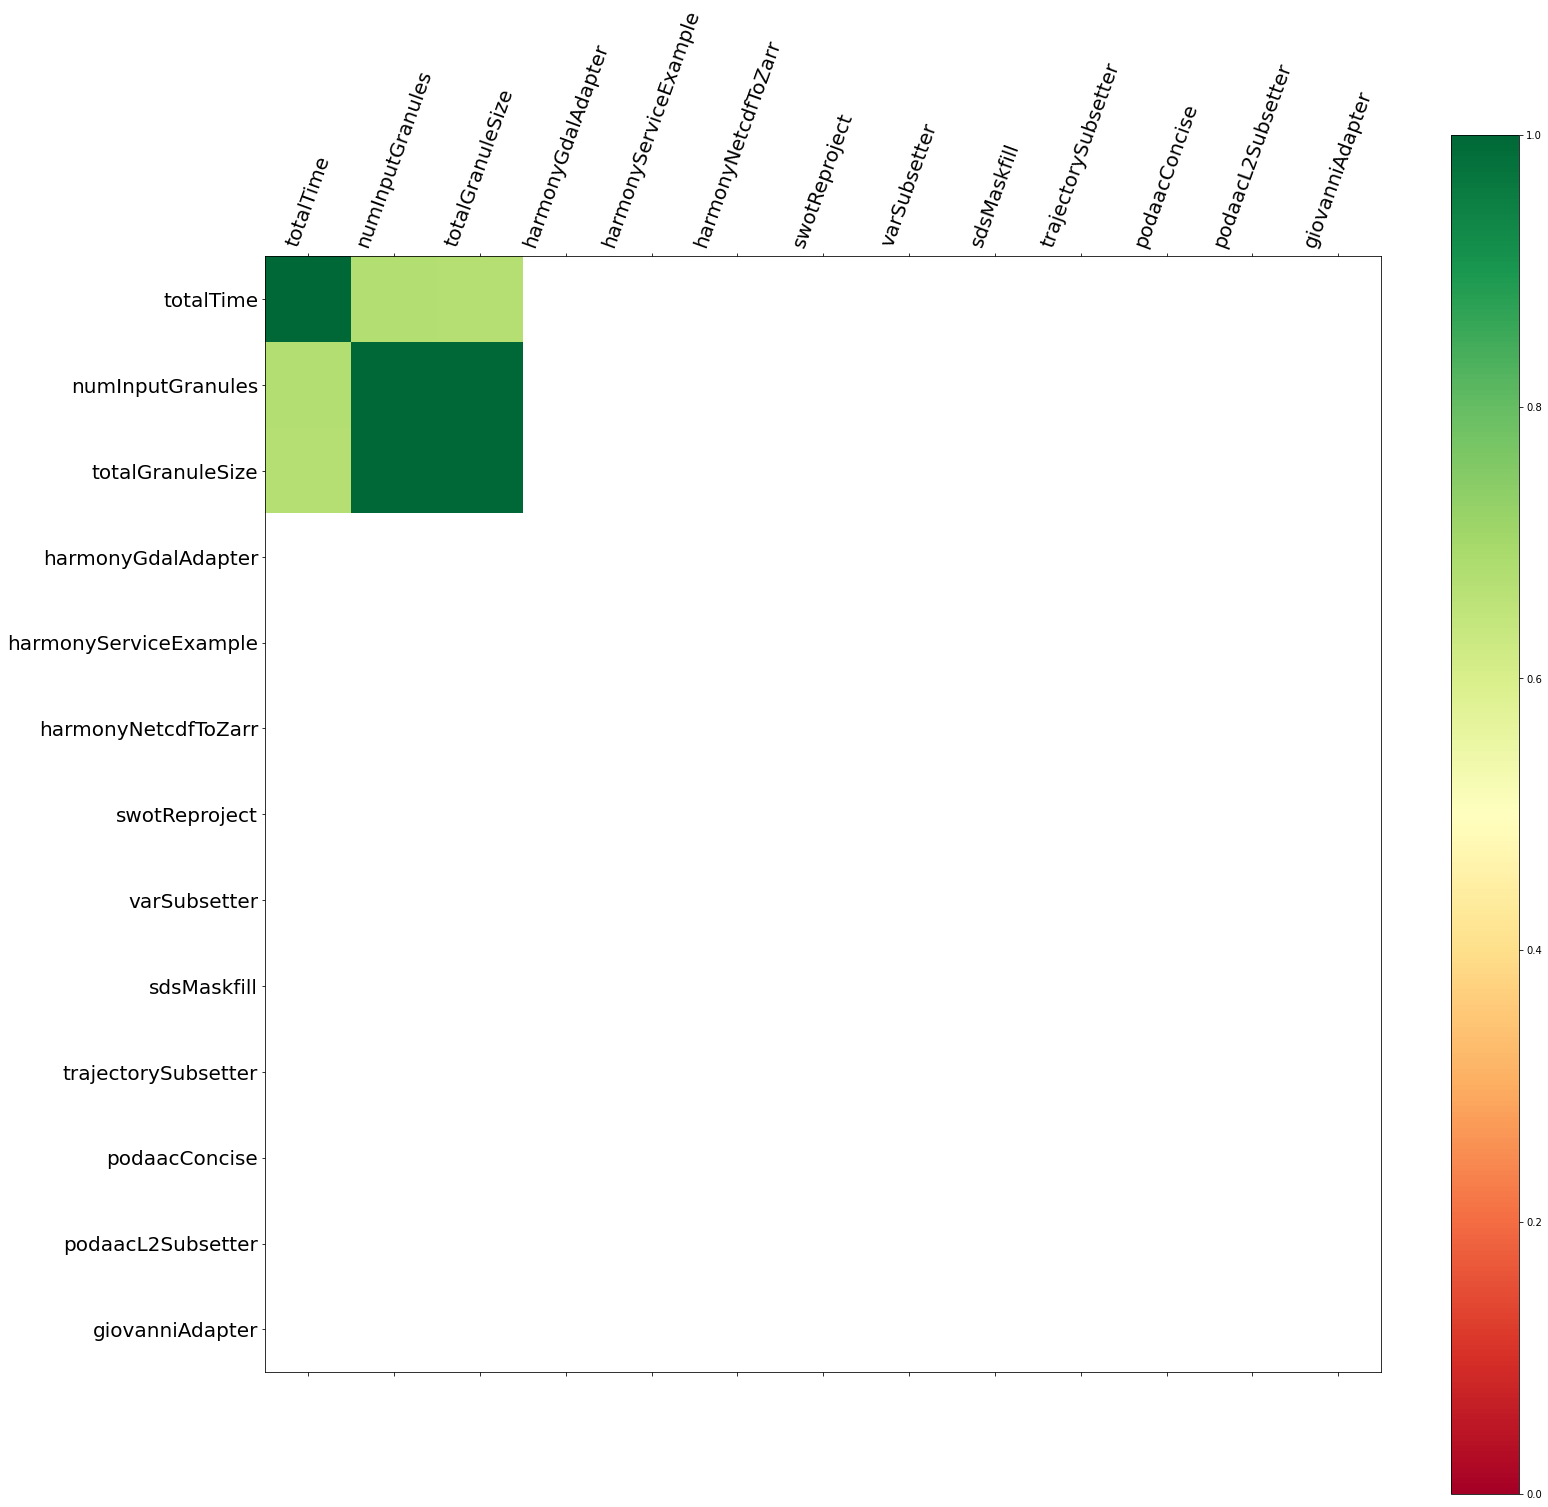

In [6]:
# Correlation Plot
df_c = df.copy()
target = 'totalTime' 
df_c = df_c.drop_duplicates().dropna()
plot_corr(df_c)

## Create Training Input/Output Sets

In [7]:
X_train = df.iloc[:,1:].values
y_train = df.iloc[:,0].values

In [8]:
X_train.shape

(266, 12)

In [9]:
y_train.shape

(266,)

In [10]:
X_train = torch.from_numpy(X_train.astype(np.float32)).view(-1,12)
y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1,1)

In [11]:
y_train.mean()

tensor(31.2366)

## 3 Layer Linear Learner Model

In [12]:
input_size=12
output_size=1

In [13]:
model = nn.Sequential(
    nn.Linear(12 , 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32,1)
)


In [14]:
learning_rate = 0.0001
l = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate )

In [15]:
num_epochs = 20000

In [16]:
for epoch in range(num_epochs):
    #forward feed
    y_pred = model(X_train.requires_grad_())

    #calculate the loss
    loss= l(y_pred, y_train)

    #backward propagation: calculate gradients
    loss.backward()

    #update the weights
    optimizer.step()

    #clear out the gradients from the last step loss.backward()
    optimizer.zero_grad()
    
    if epoch % 1000 == 0:
        print('loss {}'.format(loss.item()))

loss 1414.0196533203125
loss 253.83517456054688
loss 251.0630340576172
loss 251.38389587402344
loss 250.10302734375
loss 250.0575714111328
loss 249.2064666748047
loss 248.6868896484375
loss 248.2777862548828
loss 248.4353790283203
loss 248.31617736816406
loss 248.12535095214844
loss 248.173583984375
loss 247.96897888183594
loss 247.92962646484375
loss 247.88134765625
loss 247.93917846679688
loss 247.64732360839844
loss 248.8828125
loss 248.0543670654297


### Test Our Model With Our Training Data (bleh)

In [17]:
predicted = model(X_train).detach().numpy()

### Plot Our Actual Values And Our Predicted Values To See How Well They Track

In [18]:
def plot_predicted_vs_actual(actual, predicted):
    plt.figure(figsize=(10,10))
    plt.scatter(actual, predicted, c='crimson')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.axis('equal')
    
    # Set logarithmic scale on the both variables
    plt.xscale("log")
    plt.yscale("log");
    p1 = max(max(predicted), max(actual.numpy()))
    p2 = min(min(predicted), min(actual.numpy()))
    plt.plot([p1, p2], [p1, p2], 'b-')

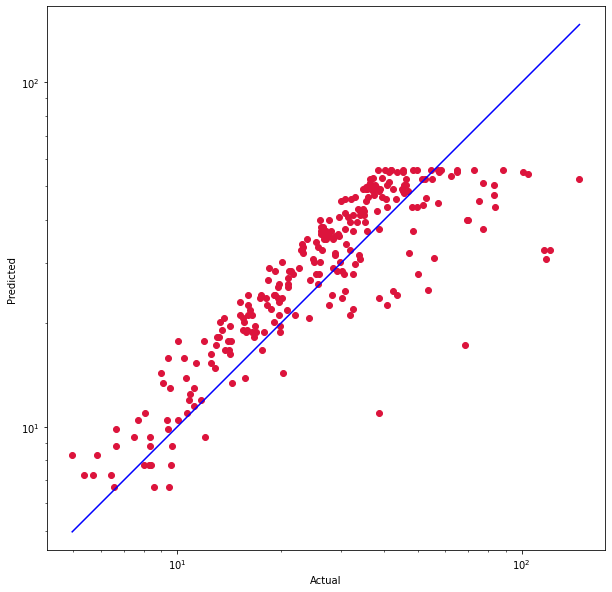

In [19]:
plot_predicted_vs_actual(y_train, predicted)

### Compute the Maxiumum Error (Max Error is About 5 Seconds When The Actual Value is Around 100 Seconds)

In [20]:
(predicted - y_train.numpy()).max()

17.208057

### Feature Impact Chart

<AxesSubplot:title={'center':'Feature Impact Chart - Correlation with Target (totalTime))'}, xlabel='Index'>

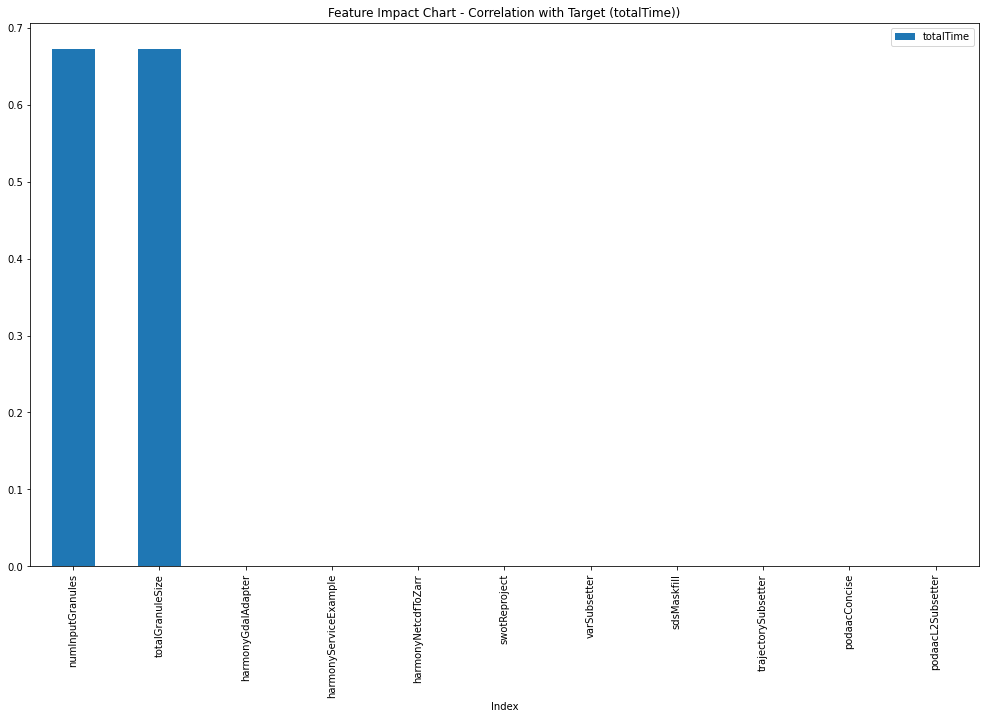

In [21]:
df_new = df_c.corr().sort_values([target], ascending = False)
df_new.drop(df_new.head(1).index, inplace=True)
df_new.drop(df_new.tail(1).index, inplace=True)
df_new['Index'] = df_new.index
chart_title = ("Feature Impact Chart - Correlation with Target (%s))" % target)
df_new.plot(x='Index', y=target, kind='bar', 
            title=chart_title,figsize=(17,10))

## XGBoost

In [22]:
model = XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

### K-Fold cross validation

In [23]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train.detach(), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [24]:
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 10.516 (2.898)


### Train

In [25]:
model.fit(X_train.detach(), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
predicted = model.predict(X_train.detach())

### Plot Our Actual Values And Our Predicted Values To See How Well They Track

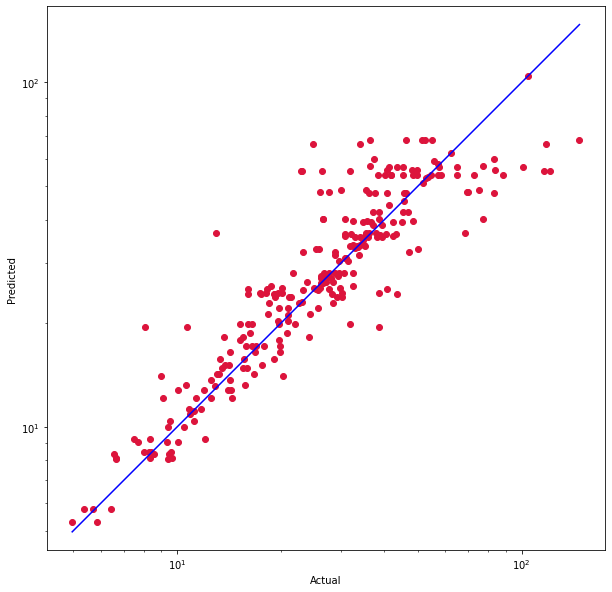

In [27]:
plot_predicted_vs_actual(y_train, predicted)